# Анализ параметров 1

In [1]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class atom():
    '''
    Параметры конкретного атома
    '''
    def __init__(self, 
                 data,
                 molecule = 0, 
                 atom = 0,
                 **kwargs):
        
        self.molecule = molecule
        self.atom = atom
        self.coord = self.get_matrix(data, 0)
        self.vel = self.get_matrix(data, 1)
        
    def get_matrix(self, data, delta):
        ''' 
        deltadelta = 0 --- coordinates
        delta = 1 --- velocities
        molecule/atom --- numbers 0,1
        '''
        start_index = self.molecule * 12 + self.atom * 6 + delta
        
        v1 = []
        for ind in range(start_index, start_index + 6, 2):
            v1.append(data[ind])
        
        return np.array(v1)

In [3]:
class molecule():
    def __init__(self,
                 data,
                 molecule=0, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        '''
        > Параметры:
        >>> k - жесткость "пружины" в молекуле;
        >>> unstretched --- расстояние между атомами при релаксации;
        '''
        self.k = k
        self.unstretched = unstretched
        self.atom0 = atom(data, molecule, 0)
        self.atom1 = atom(data, molecule, 1)
        self.vel = self.center_molecular_vel()
        self.coord = self.center_molecular_coord()
        self.M = 2.
        
    def center_molecular_vel(self):
        return (self.atom0.vel + self.atom1.vel) / 2.
    
    def center_molecular_coord(self):
        return (self.atom0.coord + self.atom1.coord) / 2.

    def interatomic_distance(self):
        return np.sqrt(np.sum((self.atom0.coord - self.atom1.coord) ** 2, axis = 0))
        
    def V_in(self):
        '''
        Потенциальная энергия V = k * (r - r0)^2
        '''
        dist = self.interatomic_distance()
    
        return self.k * ((dist - self.unstretched) ** 2)
    

    def T(self, mv = 0.0):
        '''
        Кинетическая энергия молекулы T = v^2/2
        Параметры:
        >>> mv --- скорость центра масс системы,
        >>> (т.е. для подсчёта без неё)
        '''
        vel0 = self.atom0.vel - mv
        vel1 = self.atom1.vel - mv
        return  0.5  *(np.sum(vel0 ** 2, axis = 0) + np.sum(vel1 ** 2, axis = 0))
    
    def T_c(self, mv = 0.0):
        '''
        Кинетическая энергия центра масс молекулы
        '''
        return self.M * np.sum((self.vel - mv) ** 2, axis = 0) / 2.

    def T_in(self, mv = 0.0):
        '''
        Внутренняя кинетическая энергия молекулы
        '''
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        return np.sum(v1 **2 + v2 **2, axis = 0)/2
        
    
    def Full_Energy(self, mv=0.0):
        ''' 
        полная энергия в молекуле
        '''
        return self.T(mv) + self.V_in()
    
    
    def Divided_energy(self):
        '''
        Разделим энергию на составляющие: forward, vibrational, rational 
        '''
        
        forward = self.M * np.sum(self.vel * self.vel, axis = 0) / 2.
        
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        T_in = np.sum(v1 **2 + v2 **2, axis = 0)/2
        
        # найдём вектор между двумя атомами
        vec = self.atom1.coord - self.atom0.coord
        dist = self.interatomic_distance()
        # проецируем скорости на этот вектор 
        v1_pr = (np.sum(v1 * vec, axis=0) / dist) * (vec / dist )
        v2_pr = (np.sum(v2 * vec, axis=0) / dist) * (vec / dist)

        #колебательная энергия
        vibrational = np.sum((v1_pr * v1_pr + v2_pr * v2_pr), axis = 0) / 2.0 + self.V_in()
        
        v1_r = v1 - v1_pr
        v2_r = v2 - v2_pr
        rational = np.sum((v1_r * v1_r + v2_r * v2_r)/2.0, axis = 0) 

        return forward, rational, vibrational

In [4]:
class molecular_system():
    def __init__(self, data, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        self.m0 = molecule(data, 0, k, unstretched)
        self.m1 = molecule(data, 1, k, unstretched)
        self.vel = self.center_vel()
        self.coord = self.center_coord()
        self.M = 4.
        self.m_r = (2. * 2.)/ (2.+2.)
        self.c_r = self.relative_velocity()
        
    def center_vel(self):
        '''
        Скорость центра масс системы
        '''
        return (self.m0.vel + self.m1.vel) / 2.
    
    def center_coord(self):
        '''
        Координаты центра масс системы
        '''
        return (self.m0.coord + self.m1.coord) / 2.

    def intermolecular_distance(self):
        '''
        Расстояние между молекулами
        '''
        return np.sqrt(np.sum((self.m0.coord - self.m1.coord) ** 2, axis = 0))    

    def relative_velocity(self):
        '''c_r'''
        return self.m1.vel - self.m0.vel
    
    def relative_velocity_len(self):
        '''c_r'''
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

    
    @staticmethod
    def dist2(ri,rj):
        ''' Расстояние между атомами '''
        return np.sum((ri - rj)**2, axis=0)

    
    def V_in(self):
        return self.m0.V_in() +  self.m1.V_in()
    
    
    def LD(self):
        '''
        Потенциал ЛД
        '''
        result = 0.0
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
                
        return 4 * result

    def Full_Energy(self):
        '''
        Полная энергия системы
        '''
        return self.m0.Full_Energy() + self.m1.Full_Energy()  + self.LD()
    
    
    def Full_Energy_r(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        '''
        return self.Full_Energy() - self.T_c()  #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()
    
    def Full_Energy_rt(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        и внутренней кинетической энергии молекулы
        '''
        return self.Full_Energy() - self.T_c() - self.T_in() #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()

    def T_r(self):
        '''
        Кинетическая энергия отнсительнго движения
        '''
        return self.m_r * np.sum((self.c_r  ** 2), axis=0) / 2.
    
    #def T_r(self):
    #    '''
    #    Кинетическая энергия отнсительнго движения
    #    '''
    #    return self.m_r * np.sum(((self.c_r - self.vel)  ** 2), axis=0) / 2.
    
    def T_c(self):
        '''
        Кинетическая энергия центра масс системы
        '''
        return self.M * np.sum( (self.vel ** 2) , axis = 0)/ 2.

    
    def T_in(self):
        ''' 
        Внутренняя кинетическая энергия молекулы
        '''
        return self.m0.T_in() + self.m1.T_in() 
        
    def T(self):
        '''
        Полная кинетическая энергия системы
        '''
        return self.m0.T() + self.m1.T() 
    
    def Divided_energy(self):
        forward, rational, vibrational = self.m0.Divided_energy()
        forward1, rational1, vibrational1 = self.m1.Divided_energy()
        return forward + forward1, rational + rational1, vibrational + vibrational1
    
    def length_vel(self):
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

In [5]:
class calc_system():
    def __init__(self, 
                 aiming = "0.00", num = "0", PATH =  "1/out_8/",
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        data_init, data_end = self.get_data(aiming, num, PATH)
        self.s1 = molecular_system(data_init, k, unstretched)
        self.s2 = molecular_system(data_end, k, unstretched)
        
    @staticmethod
    def to_num(init):
        for i in range(24):
            init[i] = pd.to_numeric(init[i])        
        return init    
    
    def get_data(self, aiming, num, PATH):
        init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
        end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

        del init[24]
        del end[24]

        init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        init, end = self.to_num(init), self.to_num(end)
        return init, end

    def angle(self):
        return np.mean(np.abs(np.sum(self.s1.c_r * self.s2.c_r, axis = 0)/(self.s1.length_vel() * self.s2.length_vel())))
    
    def diff_c_r(self):
        return self.s1.vel - self.s2.vel
    
    def lmbd(self):
        '''Лямбда'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_r())
        
        
    def lmbd2(self):
        '''для подсчёта лямбда'''
        return  np.sum(self.s1.T_r()), np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()), np.sum(self.s2.Full_Energy_r())
        
    def lmbd_1(self):
        '''Лямбда без внутренней кинетической энергии'''
        return  np.mean(self.s1.T_r() / self.s1.Full_Energy_r()),\
                np.mean(self.s2.T_r() / self.s2.Full_Energy_r())
    
    def Full_Energy(self):
        return self.s1.Full_Energy(),  self.s2.Full_Energy()
    
    def V_in(self):
        return self.s1.V_in(), self.s2.V_in()
    
    
    def LD(self):
        return self.s1.LD(),  self.s2.LD()
    
    
    def Kinetik(self):
        return  self.s1.T_in(),\
                self.s1.T_c(),\
                self.s1.T_r(),\
                self.s1.T(),\
                self.s2.T_in(),\
                self.s2.T_c(),\
                self.s2.T_r(),\
                self.s2.T()

In [6]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 1.9, 
                 step_b = 0.2):
    '''
    Соберём следующие статистические параметры:
     1. косинс угла
     2. lambda до и после
     3. lambda_1 до и после
     4. Перераспределение T_in, T_c, T_r, H, LD, V_in, T
    '''
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = "%.1lf"%(b) + "0" 
        
        for v in range(END_FILE_NUM):
            v_in = str(v)
            s = calc_system(b_in, v_in, PATH)
            
            # lambda
            lmbd1, lmbd2 = s.lmbd()
            lmbd1_t, lmbd2_t = s.lmbd_1()
            
            # угол
            angle = s.angle()
            
            # T
            T1,H1,T2,H2 = s.lmbd2()
            c_r_i = np.mean(s.s1.relative_velocity_len())
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            
            b_str = "%0.1lf"%(b)
            
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['angle'] = [] 
                
                result_v[c_r_i_str]['l1'] = []          
                result_v[c_r_i_str]['l2'] = []             
                result_v[c_r_i_str]['l1_t'] = []          
                result_v[c_r_i_str]['l2_t'] = [] 
                   
                result_v[c_r_i_str]['H1'] = []          
                result_v[c_r_i_str]['H2'] = []             
                result_v[c_r_i_str]['T1'] = []          
                result_v[c_r_i_str]['T2'] = [] 
                   
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                result_b[b_str]['angle'] = []
                
                result_b[b_str]['l1'] = []          
                result_b[b_str]['l2'] = []             
                result_b[b_str]['l1_t'] = []          
                result_b[b_str]['l2_t'] = [] 
                
                result_b[b_str]['H1'] = []        
                result_b[b_str]['H2'] = []            
                result_b[b_str]['T1'] = [] 
                result_b[b_str]['T2'] = [] 
            
            # добавляем свойства по c_r
            result_v[c_r_i_str]['angle'].append(angle)
            result_v[c_r_i_str]['b'].append(b)
            
            result_v[c_r_i_str]['l1'].append(lmbd1)       
            result_v[c_r_i_str]['l2'].append(lmbd2)          
            result_v[c_r_i_str]['l1_t'].append(lmbd1_t)          
            result_v[c_r_i_str]['l2_t'].append(lmbd2_t) 
            
            
            result_v[c_r_i_str]['H1'].append(H1)       
            result_v[c_r_i_str]['H2'].append(H2)          
            result_v[c_r_i_str]['T1'].append(T1)          
            result_v[c_r_i_str]['T2'].append(T2) 
            
            # добавляем свойства по b
            result_b[b_str]['v'].append(c_r_i)
            result_b[b_str]['angle'].append(angle)
            
            result_b[b_str]['l1'].append(lmbd1)        
            result_b[b_str]['l2'].append(lmbd2)            
            result_b[b_str]['l1_t'].append(lmbd1_t)    
            result_b[b_str]['l2_t'].append(lmbd2_t)

            result_b[b_str]['H1'].append(H1)        
            result_b[b_str]['H2'].append(H2)            
            result_b[b_str]['T1'].append(T1)    
            result_b[b_str]['T2'].append(T2)
    
    return result_v, result_b

# Подсчёт параметров

In [7]:
def update(old, new):
    for key in new.keys():
        if key not in old.keys():
            old[key] = {}
            
        for in_key in new[key].keys():
            
            if in_key not in old[key].keys():
                old[key][in_key] = []
            
            old[key][in_key] += new[key][in_key]
    return old

In [8]:
result_v = {}
result_b = {}

v,b = process_full(END_b = 1.9)

result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="2/out_2/", 
                       END_FILE_NUM=3,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="3/out_1/", 
                       END_FILE_NUM=5,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="4/out_3/", 
                       END_FILE_NUM=9,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out/", 
                   END_FILE_NUM=19,
                   START_b = 2.0,
                   END_b = 3.5)
result_v = update(result_v, v)
result_b = update(result_b, b)


#v,b = process_full(PATH="big_vel/", 
#                   END_FILE_NUM=6,
#                   START_b = 1.0,
#                   END_b = 1.7)
#result_v = update(result_v, v)
#result_b = update(result_b, b)

100%|██████████| 8/8 [00:29<00:00,  3.71s/it]


In [9]:
def arraying(arr):
    for i in arr:
        for j in arr[i]:
            arr[i][j] = np.array(arr[i][j])
    return arr

result_v = arraying(result_v)
result_b = arraying(result_b)

# Параметр $\gamma$

Посчитаем параметр 
$$
\gamma = \frac{\frac{m_r}{2} (c_r^2 - {c'}_r^2)}{H_r} = \frac{T_r - T_r'}{H_r} = \lambda_{init} - \lambda_{end} 
$$

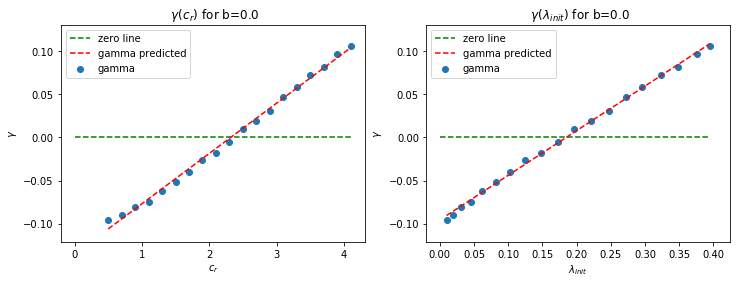

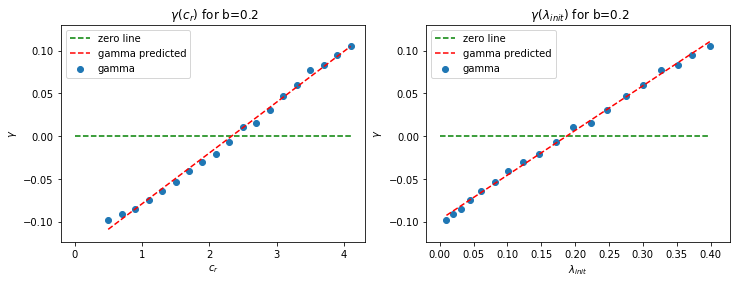

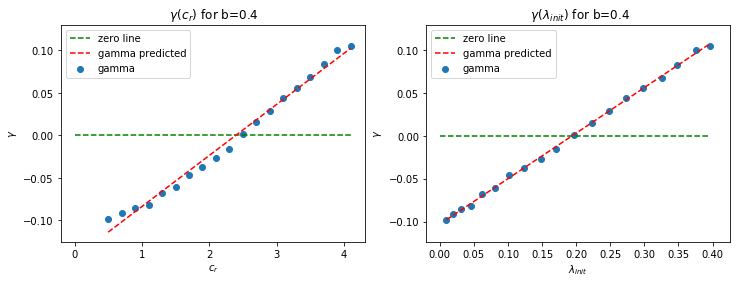

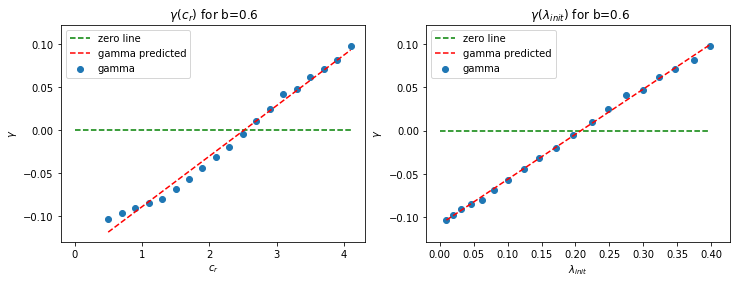

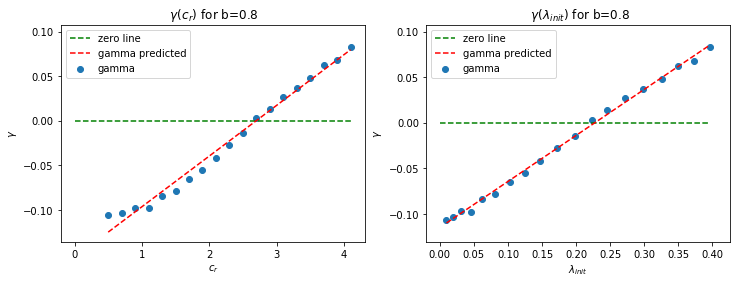

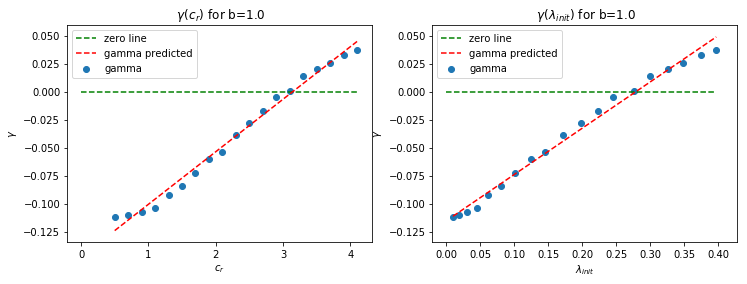

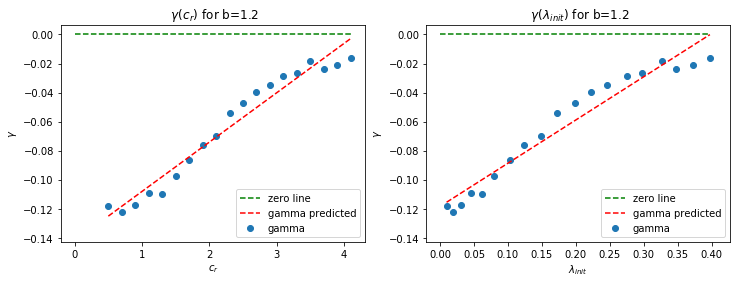

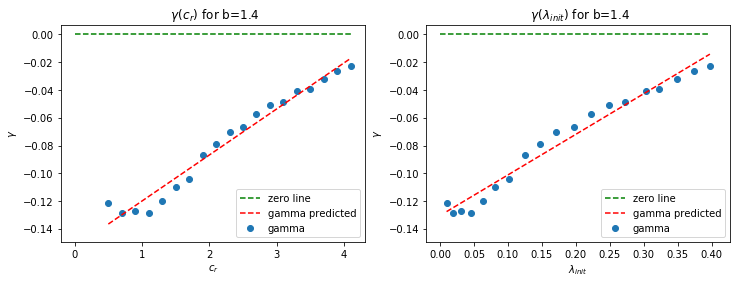

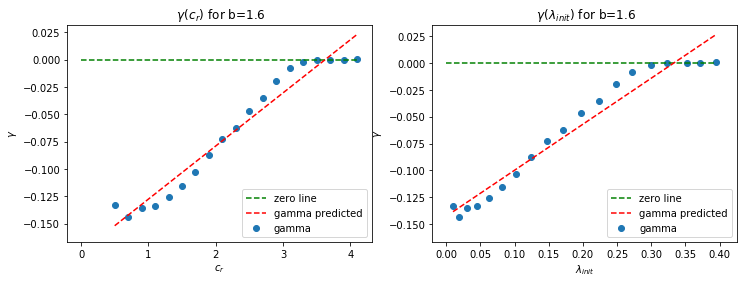

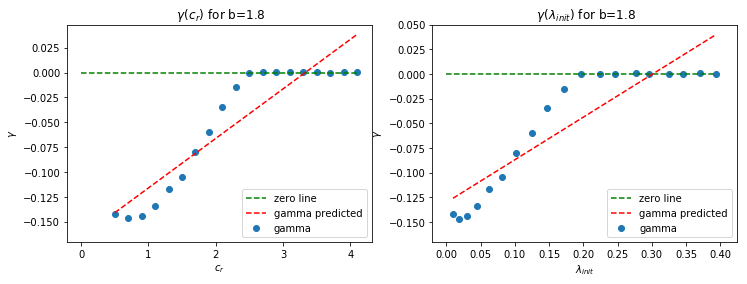

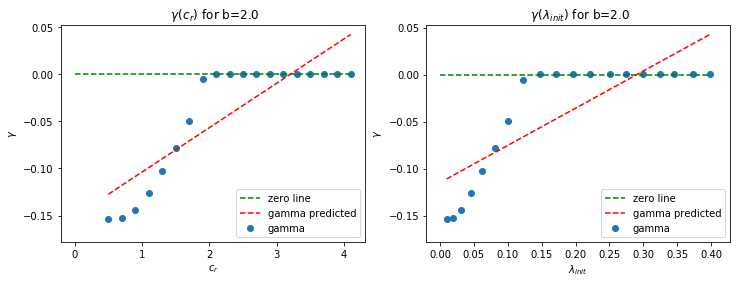

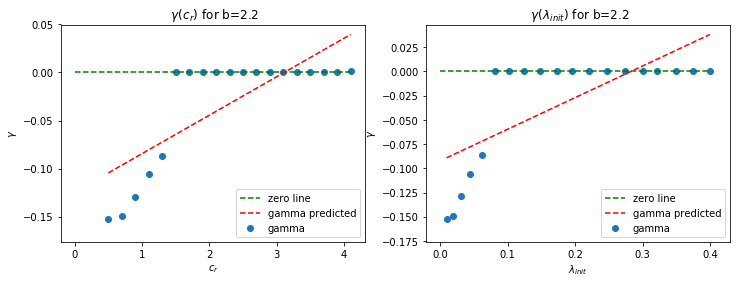

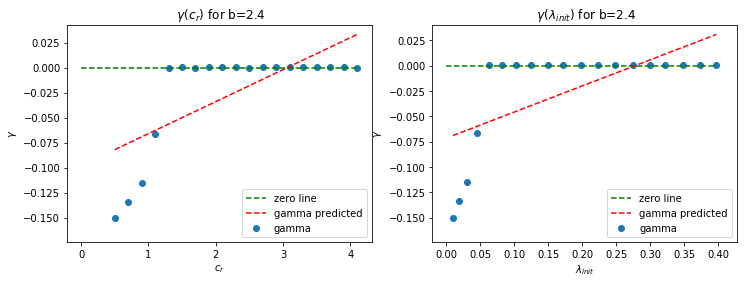

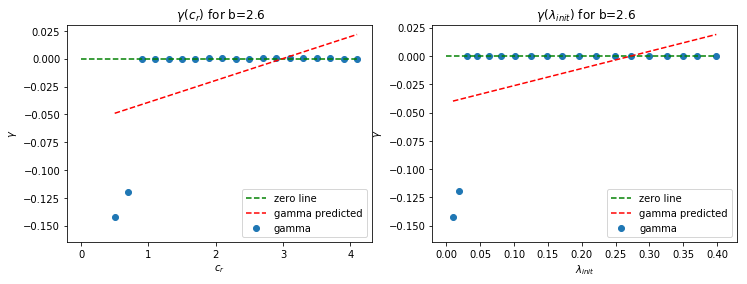

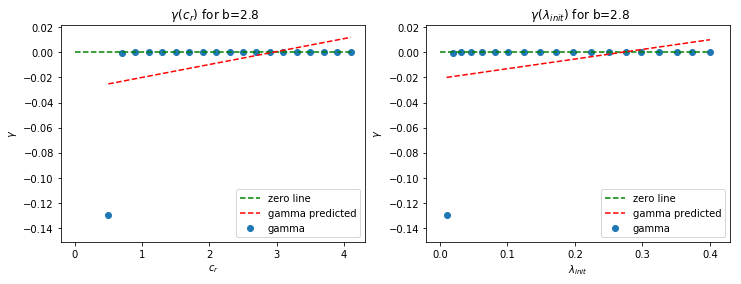

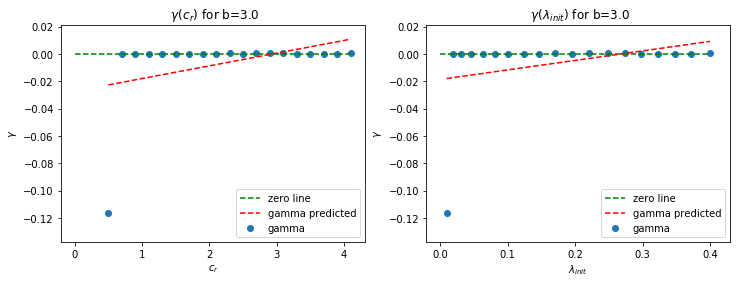

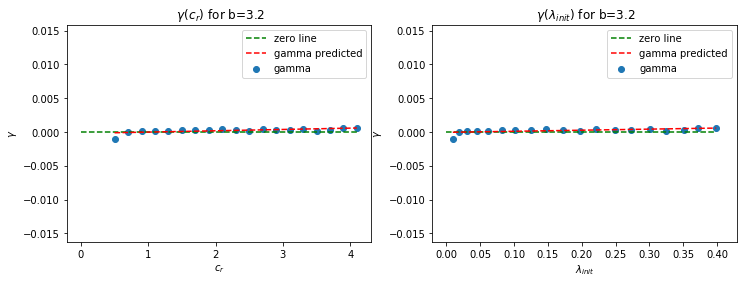

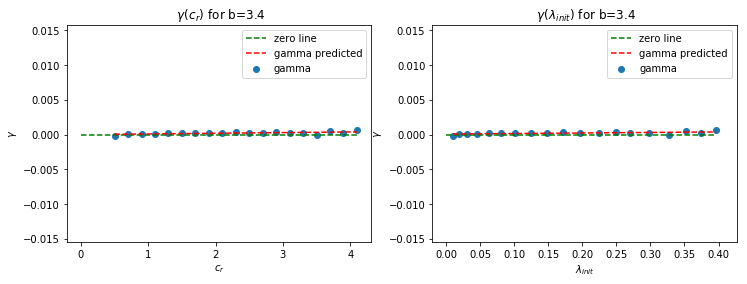

In [10]:
for b in sorted(result_b.keys()):
    gamma = result_b[b]["l1"] - result_b[b]["l2"]
    
    plt.figure(1, figsize=(12,4))
    plt.subplot(121)
    plt.scatter(result_b[b]['v'], gamma, label = "gamma")
    plt.plot([0. ,np.max(result_b[b ]['v'])], [0. ,0], "g--",label = "zero line")
    
    fit = np.polyfit(result_b[b]['v'],gamma,1)
    fit_fn = np.poly1d(fit) 
    plt.plot(result_b[b]['v'], fit_fn(result_b[b]['v']), 'r--', label = "gamma predicted")
    
    # подсчёт параметров    
    plt.xlabel('$c_r$')
    plt.ylabel('$\gamma$')    
    plt.legend()
    plt.title(' $\gamma(c_r)$ for b=%s'%(b))
    
    plt.subplot(122)
    plt.scatter(result_b[b]["l1"], result_b[b]["l1"] - result_b[b]["l2"], label = "gamma")
    plt.plot([0. ,np.max(result_b[b ]['l1'])], [0. ,0], "g--", label = "zero line")
    
    fit = np.polyfit(result_b[b]['l1'],gamma,1)
    fit_fn = np.poly1d(fit) 
    plt.plot(result_b[b]['l1'], fit_fn(result_b[b]['l1']), 'r--', label = "gamma predicted")
    
    plt.xlabel('$\lambda_{init}$')
    plt.ylabel('$\gamma$')    
    plt.title(' $\gamma(\lambda_{init})$ for b=%s'%(b))
    plt.legend()
    plt.show()



### Выводы:
    1. До b = 1.0 явна видна линейная зависимость.
    2. При b > 1.0 начинают появляться скорости, при которых молекулы перестают замечать друг друга. 
    Зависимость перестаёт быть линейной.
        a. Есть смысл определить c_r, при которой для каждого b молекулы перестают замечать друг друга. И рассмтривать зависимость до этой величины.
        b. Для b > 1.0, где графики $\gamma$ не вышли на 0, насчитаем дополнительные большие скорости.
    3. Определим b_max для каждого c_r, при котором молекулы перестют друг друга замечать.

# Зависимость косинуса угла $\alpha$ от изменения $c_r$ при разных $b$

Рассмотрим графики $\alpha (c_r)$ и  $\alpha (\lambda_{init})$, где 
$$
\alpha = \cos(angle)
$$

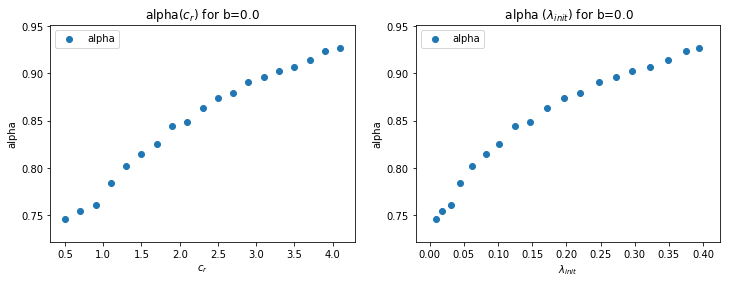

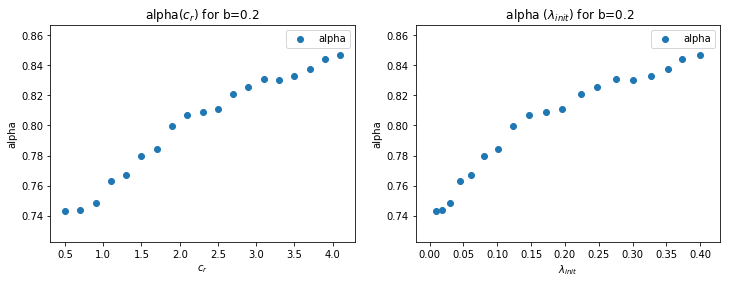

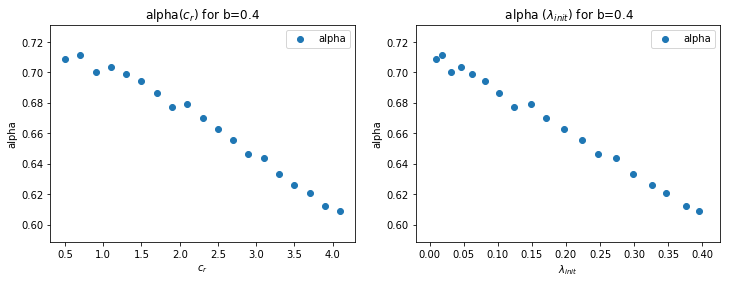

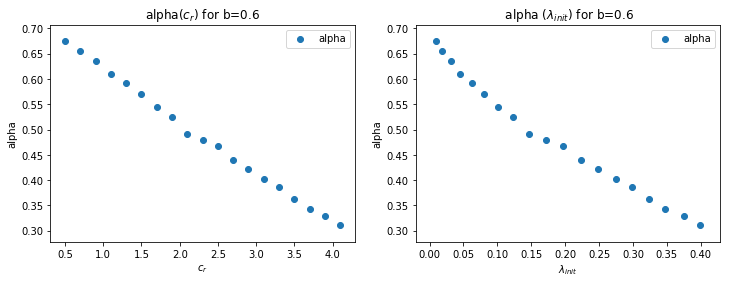

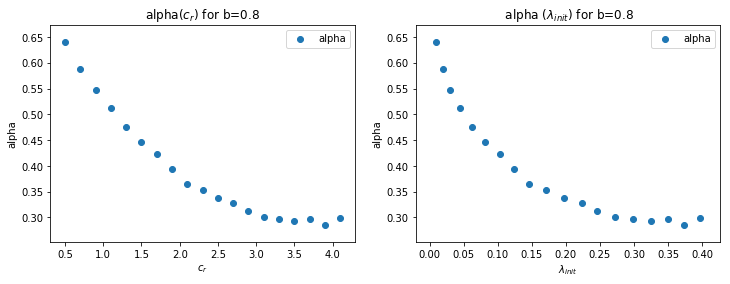

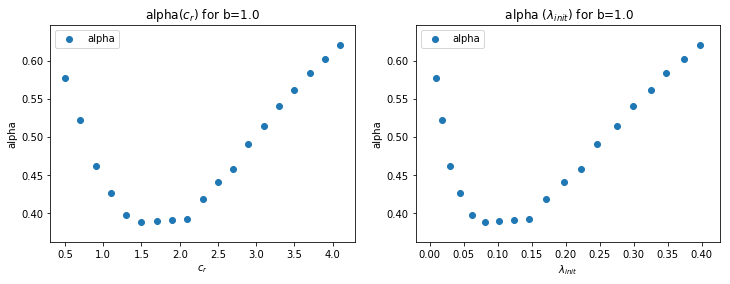

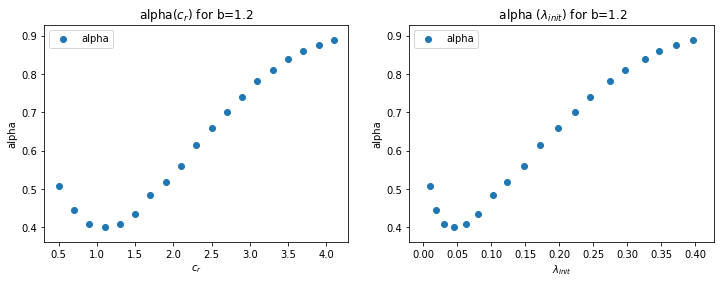

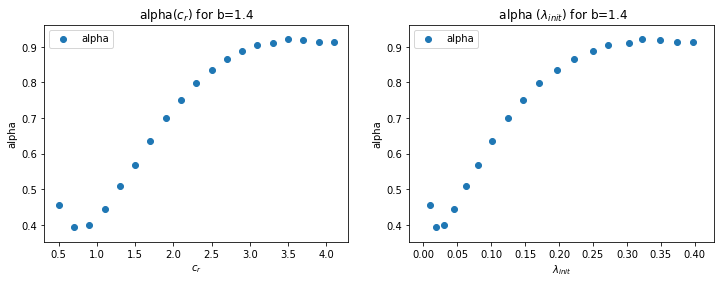

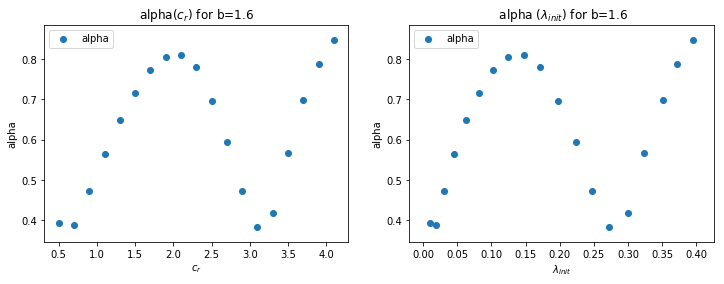

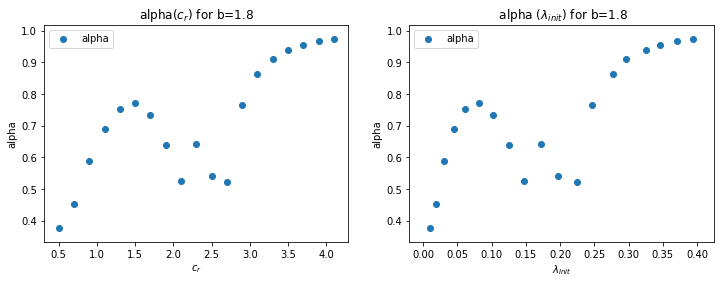

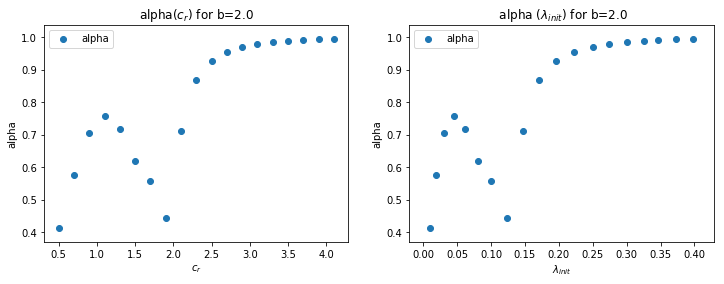

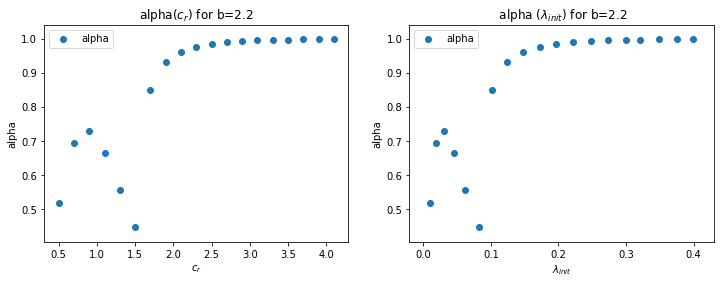

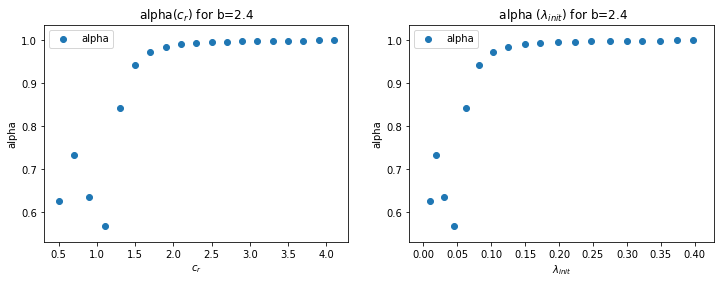

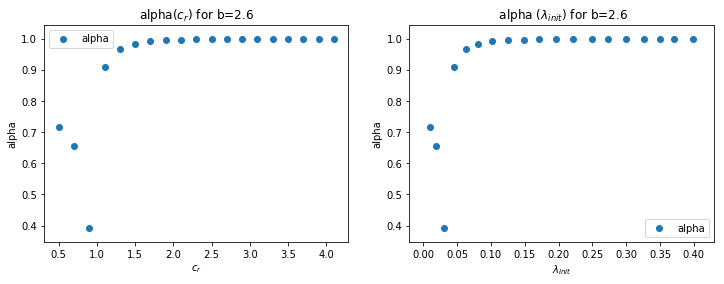

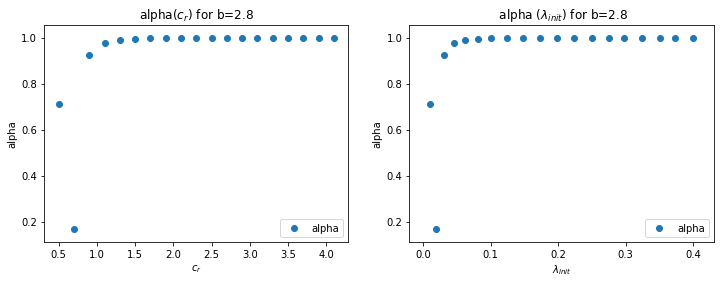

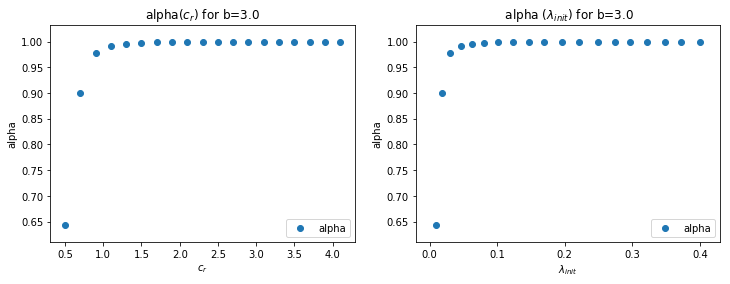

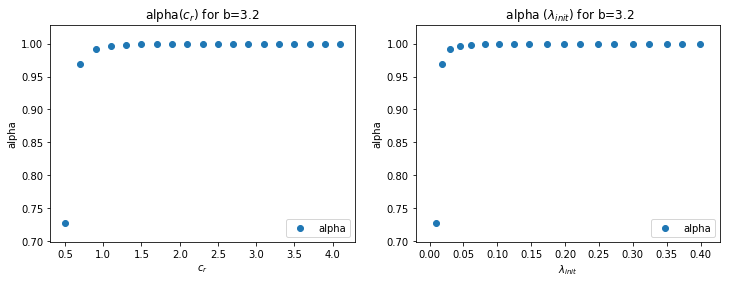

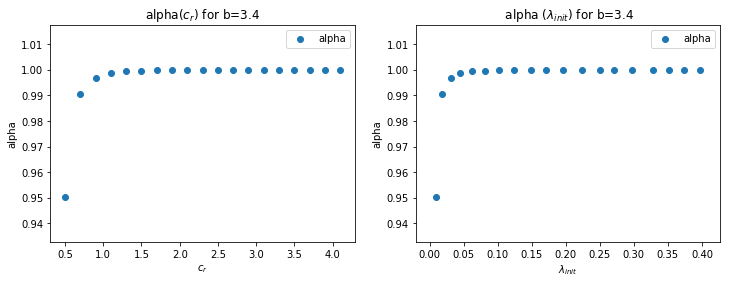

In [11]:
for b in sorted(result_b.keys()):
    
    plt.figure(1, figsize=(12,4))
    plt.subplot(121)
    plt.scatter(result_b[b]['v'], result_b[b]['angle'], label = "alpha")
    #plt.plot([0. ,np.max(result_b[b ]['v'])], [0. ,0], "g--",label = "zero line")
    
    #fit = np.polyfit(result_b[b]['v'],gamma,1)
    #fit_fn = np.poly1d(fit) 
    #plt.plot(result_b[b]['v'], fit_fn(result_b[b]['v']), 'r--', label = "gamma predicted")
    
    # подсчёт параметров    
    plt.xlabel('$c_r$')
    plt.ylabel('alpha')    
    plt.legend()
    plt.title('alpha($c_r$) for b=%s'%(b))
    
    
    
    plt.subplot(122)
    plt.scatter(result_b[b]['l1'], result_b[b]['angle'], label = "alpha")
    
    #plt.scatter(result_b[b]["l1"], result_b[b]["l1"] - result_b[b]["l2"], label = "gamma")
    #plt.plot([0. ,np.max(result_b[b ]['l1'])], [0. ,0], "g--", label = "zero line")
    
    #fit = np.polyfit(result_b[b]['l1'],gamma,1)
    #fit_fn = np.poly1d(fit) 
    #plt.plot(result_b[b]['l1'], fit_fn(result_b[b]['l1']), 'r--', label = "gamma predicted")
    
    plt.xlabel('$\lambda_{init}$')
    plt.ylabel('alpha')    
    plt.title(' alpha $(\lambda_{init})$ for b=%s'%(b))
    plt.legend()
    plt.show()




### Вывод:
    1. На больших прицельных расстояниях молекулы пперестают друг друга замечать, соответственно угол перестаёт меняться.
    2. Среднее значение угла можно оценить так:
        a. на очень малых прицельных расстояниях (лобовой удар) косинус угла стремиться к 1.
        b. С ростом прицельного расстояния, пока молекулы не начинают переставать замечать друг друга, косинус угла начинает стремиться к 0 с увеличением скорости.
        c. Молекулы не замечают друг друга, косинус угла снова становится 1.
        d. При средних зачения прицельного расстояния на малых скоростях имеется сложная нелинейная зависимость, но при увеличении скорости косинус угла так же стремится к 1.

# Зависимость косинуса угла $\alpha$ от изменения $b$ при разных $c_r$



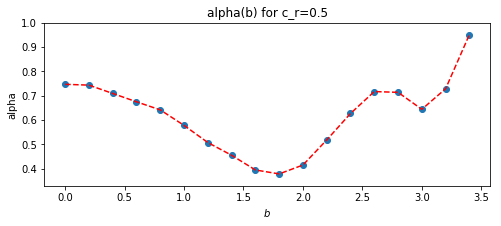

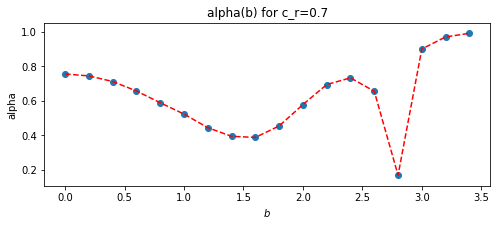

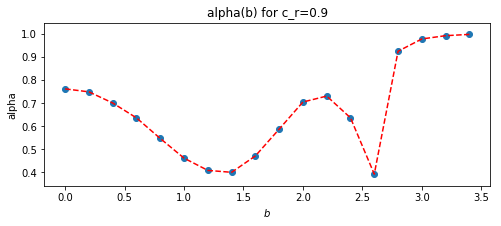

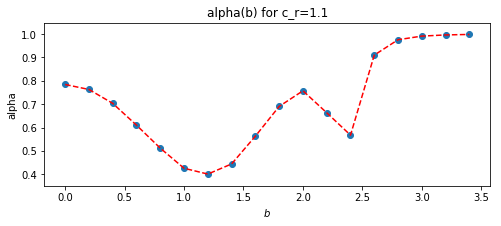

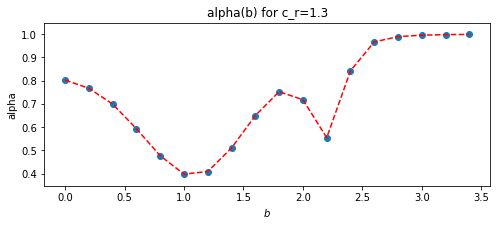

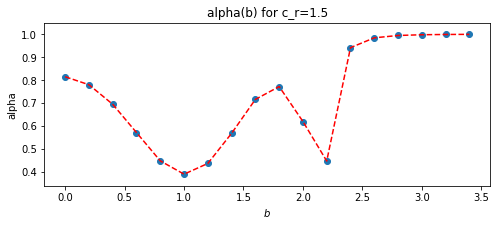

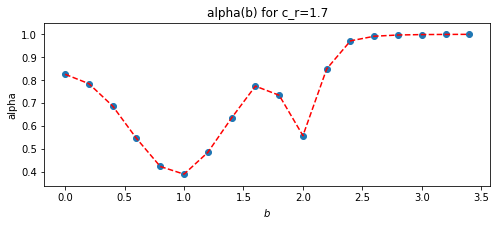

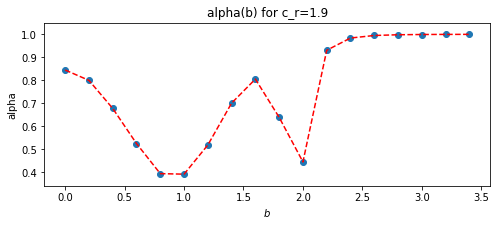

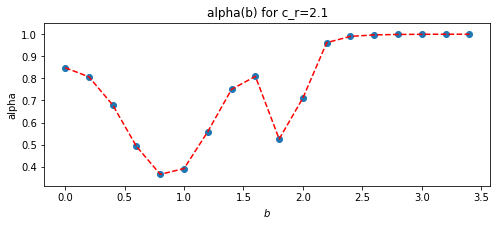

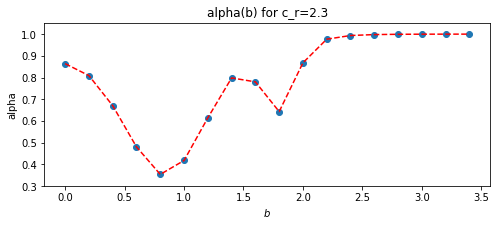

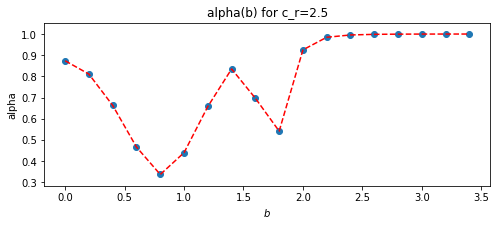

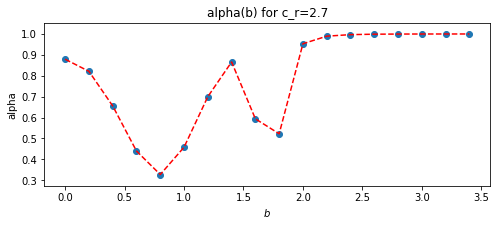

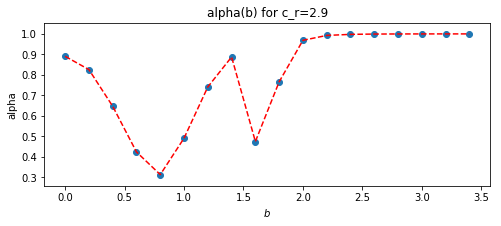

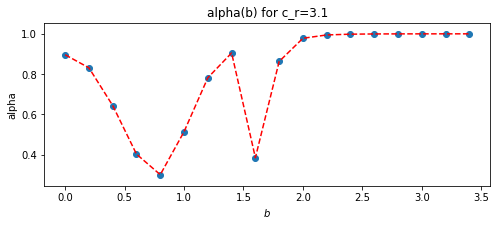

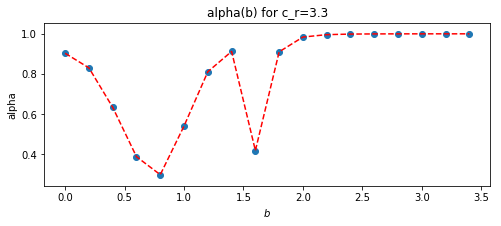

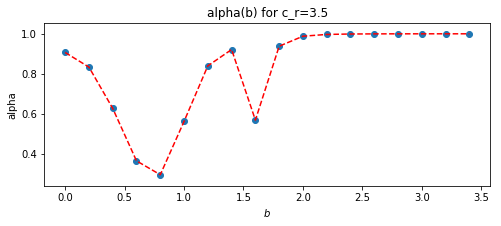

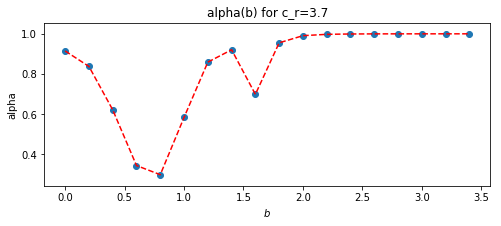

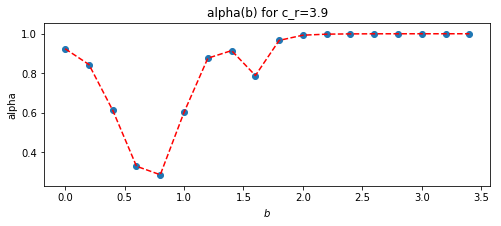

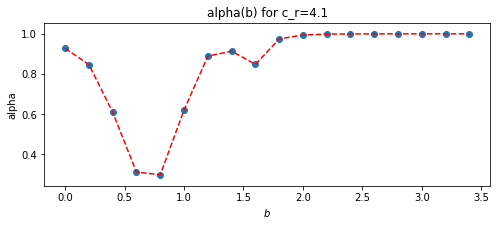

In [12]:
for b in sorted(result_v.keys()):
    
    plt.figure(1, figsize=(8,3))
    plt.scatter(result_v[b]['b'], result_v[b]['angle'], label = "alpha")
    plt.plot(result_v[b]['b'], result_v[b]['angle'], "r--", label = "alpha")
    #plt.plot([0. ,np.max(result_b[b ]['v'])], [0. ,0], "g--",label = "zero line")
    
    #fit = np.polyfit(result_b[b]['v'],gamma,1)
    #fit_fn = np.poly1d(fit) 
    #plt.plot(result_b[b]['v'], fit_fn(result_b[b]['v']), 'r--', label = "gamma predicted")
    
    # подсчёт параметров    
    plt.xlabel('$b$')
    plt.ylabel('alpha')    
    #plt.legend()
    plt.title('alpha(b) for c_r=%s'%(b))
    plt.show()

### Выводы:
    1. Для каждого c_r существует b, когда молекулы перестают замечать друг друга;
    2. Для каждого с_r имеются 3 этапа:
        a. Малые b -- линейная зависимость. Косинус угла уменьшается при увеличении прицельного расстояния. (стремимся к 90 градусам.
        b. Средние b -- нелинейная зависимость (везде заметен тренд: рост, убывание, рост)
        c. Большие b --- молекулы перестают замечать друг друга.
        
Необходимо: определить максимальные значения b для разных $c_r$, когда молекулы перестают замечать друг друга

# Максимальные значения b для разных c_r, когда молекулы перестают замечать друг друга (не меняется угол)

In [13]:
def find_b_max(result_v):
    b_max = []
    c_r = []
    lmbd = []
    for i in sorted(result_v.keys()):
        for j, el in enumerate(np.abs(np.array(result_v[i]['angle']))[::-1]):
            if 1. - el > 0.1:
                break
        b_max.append( result_v[i]['b'][-j])
        lmbd.append( result_v[i]['l1'][-j])
        c_r.append(float(i))
    return b_max, c_r, lmbd

b_max, c_r, lmbd = find_b_max(result_v)

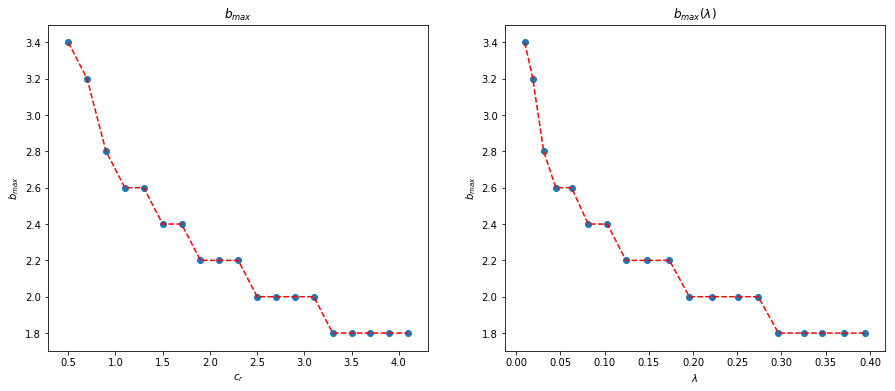

In [14]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.plot(c_r, b_max, 'r--')
plt.scatter(c_r, b_max)
plt.xlabel('$c_r$')
plt.ylabel('$b_{max}$')    
#plt.legend()
plt.title('$b_{max}$')
plt.subplot(122)
plt.plot(lmbd, b_max, 'r--')
plt.scatter(lmbd, b_max)
plt.xlabel('$\lambda$')
plt.ylabel('$b_{max}$')    
#plt.legend()
plt.title('$b_{max}$($\lambda$)')
plt.show()

### Выводы:
    1. Зависимость b_max(c_r) --- ступенчатая, похожа на экспоненциальную.

# Найдём максимальные $c_r$ и $\lambda$ для каждого $b$ (не меняется угол)

In [15]:
b_max, c_r, lmbd = find_b_max(result_v)

b_max = b_max[::-1]
c_r = c_r[::-1]
lmbd = lmbd[::-1]

pr = b_max[0]

lmbd_max = []
c_max = []
b = []

for ind, el in enumerate(b_max):
    if (pr != el):
        c_max.append(c_r[ind-1])
        lmbd_max.append(lmbd[ind-1])
        b.append(pr)
        pr = el
        
c_max.append(c_r[-1])        
lmbd_max.append(lmbd[-1])
b.append(b_max[-1])

In [16]:
bbs = []
best_ll = []
best_cr = []
for b_i in sorted(result_b.keys()):
    for ind, isPass in enumerate((np.abs(result_b[b_i]['angle'] - 1) < 0.5e-1)[::-1]):
        if not isPass:
            break
    
    if (ind == 0):
        continue
    bbs.append(float(b_i))
    best_ll.append(result_b[b_i]['l1'][::-1][ind-1])
    best_cr.append(result_b[b_i]['v'][::-1][ind-1])

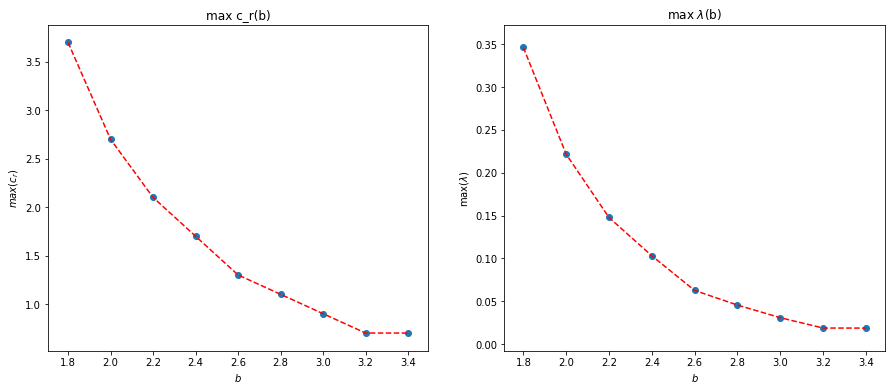

In [17]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(bbs, best_cr, 'r--')
plt.scatter(bbs, best_cr)
plt.ylabel('$max(c_r)$')
plt.xlabel('$b$')    
plt.title('max c_r(b)')

plt.subplot(122)
plt.scatter(bbs, best_ll)
plt.plot(bbs, best_ll, 'r--')
plt.ylabel('$\max (\lambda)$')
plt.xlabel('$b$')  
plt.title('max $\lambda$(b)')
plt.show()

### Выводы:
    1. Зависимость max c_r(b) --- похожа на экспоненциальную.
    2. Заметно, что при b = 1.8, max(lambda) = 0.3,  однако графики для gamma показывают, что при b = 1.8, lambda перестаёт меняться после max(lambda) = 0.2

# Найдём максимальные $\lambda$ для каждого $b$ (после которого не меняется $\lambda$)

In [18]:
bs = []
best_l = []
best_c = []
for b_i in sorted(result_b.keys()):
    for ind, isPass in enumerate((np.abs(result_b[b_i]['l2'] - result_b[b_i]['l1']) < 1e-3)[::-1]):
        if not isPass:
            break
    
    if (ind == 0):
        continue
    bs.append(float(b_i))
    best_l.append(result_b[b_i]['l1'][::-1][ind])
    best_c.append(result_b[b_i]['v'][::-1][ind])

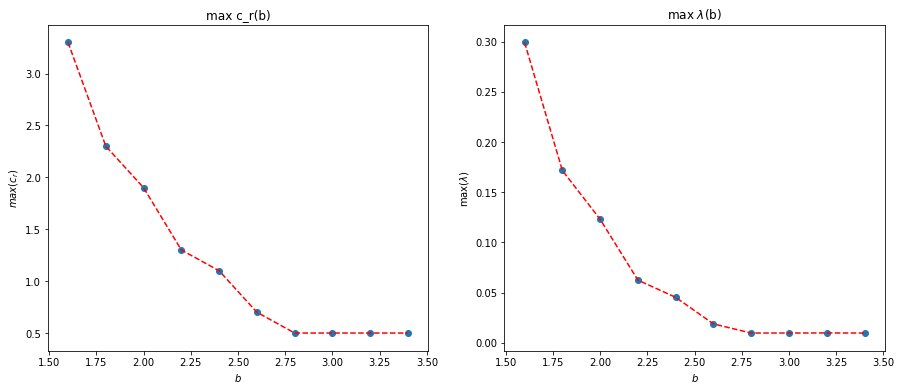

In [19]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(bs, best_c, 'r--')
plt.scatter(bs, best_c)
plt.ylabel('$max(c_r)$')
plt.xlabel('$b$')    
plt.title('max c_r(b)')

plt.subplot(122)
plt.plot(bs, best_l, 'r--')
plt.scatter(bs, best_l)
plt.ylabel('$\max (\lambda)$')
plt.xlabel('$b$')    
plt.title('max $\lambda$(b)')
plt.show()

# Сравнение $\max(\lambda)$ для угла и $\gamma$

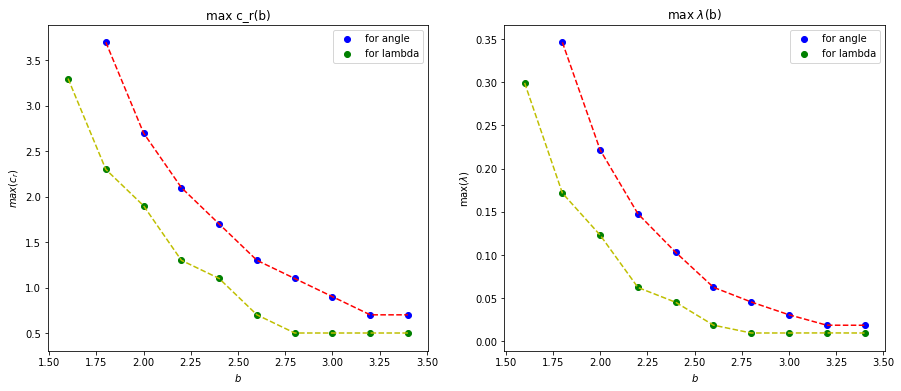

In [21]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(bbs, best_cr, 'r--')
plt.scatter(bbs, best_cr, c = "b", label = "for angle")
plt.plot(bs, best_c,'y--')
plt.scatter(bs, best_c, c = 'g', label = "for lambda")
plt.ylabel('$max(c_r)$')
plt.xlabel('$b$')    
plt.title('max c_r(b)')
plt.legend()

plt.subplot(122)
plt.plot(bbs, best_ll, 'r--')
plt.scatter(bbs, best_ll, c = "b", label = "for angle")
plt.plot(bs, best_l, 'y--')
plt.scatter(bs, best_l, c = 'g', label = "for lambda")
plt.ylabel('$\max (\lambda)$')
plt.xlabel('$b$')    
plt.legend()
plt.title('max $\lambda$(b)')
plt.show()

### Выводы:
    1. Заметно, что $\lambda$ перестают меняться при меньших b, чем углы.